In [1]:
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt

Make sure we are in the right directory.

In [2]:
ls data

2d_gaussian.png                   Penobscot_0-1000ms.sgy
31_81_PR.sgy                      Penobscot_HorizonB.txt
F03-04.las*                       Penobscot_HorizonC.txt
F3_MFS4_Horizon.txt               Penobscot_HorizonC_header.txt
F3_Seismic_500-1500ms.txt         Penobscot_NumPy.npy.gz
F3_very_small.sgy                 Penobscot_NumPy_.npy
HUN00-ALT-01_STK.sgy              Penobscot_Seabed.npy
M-MG-70_14.3_135.9.png            Penobscot_Seabed.txt
Nova_Scotia.sgy                   crop_very_tall.jpg
P-129_280_1935.png                crop_very_wide.jpg
P-129_out.LAS*                    ld0057_file_00095.sgy
P-129_striplog_from_cuttings.las  moduli.png
P-129_striplog_from_image.las     out.sgy
P-63_cuttings.csv                 test.jpeg
Penobscot.h5                      test.sgy


In [5]:
data = np.loadtxt('../geocomp-0118/data/Penobscot_xl1155.txt')

Inspect the first ten rows.

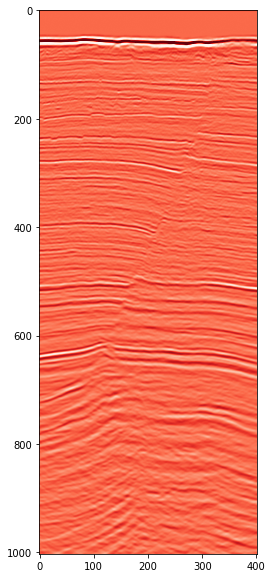

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(data.T, cmap='Reds', vmin=-7000, vmax=7000, interpolation='bicubic')

In [5]:
inlines = 748 - 104 + 1
xlines = 1248 - 302 + 1

print(inlines, 'inlines')
print(xlines, 'crosslines')

645 inlines
947 crosslines


We'll transform the first two columns to normalized versions of inline and crossline.

In [6]:
data[:,0] -= 103 
data[:,1] -= 301

In [7]:
data[:10]

array([[  1.00000000e+00,   1.00000000e+00,   8.58863175e+02,
         -2.26600000e+03],
       [  2.00000000e+00,   1.00000000e+00,   8.58552575e+02,
         -2.21100000e+03],
       [  2.00000000e+00,   2.00000000e+00,   8.58641624e+02,
         -1.56400000e+03],
       [  2.00000000e+00,   3.00000000e+00,   8.58751655e+02,
         -7.56000000e+02],
       [  2.00000000e+00,   4.00000000e+00,   8.58882606e+02,
         -4.22000000e+02],
       [  2.00000000e+00,   5.00000000e+00,   8.59029293e+02,
          2.14000000e+02],
       [  2.00000000e+00,   6.00000000e+00,   8.58526349e+02,
          4.13000000e+02],
       [  2.00000000e+00,   7.00000000e+00,   8.57745767e+02,
          3.58000000e+02],
       [  2.00000000e+00,   8.00000000e+00,   8.56708467e+02,
          1.20300000e+03],
       [  2.00000000e+00,   9.00000000e+00,   8.55550647e+02,
          5.60000000e+01]])

Make an empty array with the same shape. We're going to put our data in here.

In [8]:
horizon = np.empty((inlines, xlines))
print(horizon)
print(horizon.shape)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(645, 947)


In [9]:
amplitude = np.empty((inlines, xlines))

for sample in data:
    inline = int(sample[0])
    xline = int(sample[1])
    z_value = sample[2]
    amp_value = sample[3]
    
    horizon[inline - 1, xline - 1] = z_value
    amplitude[inline - 1, xline - 1] = amp_value

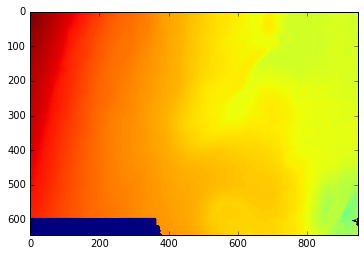

In [10]:
plt.imshow(horizon)
plt.show()

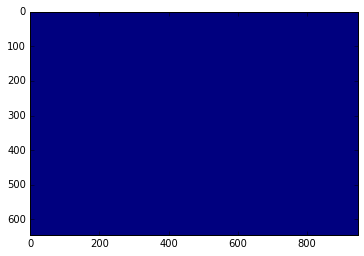

In [11]:
plt.imshow(amplitude)
plt.show()

In [12]:
np.amin(amplitude), np.amax(amplitude)

(-23221.0, 1e+30)

The max value is a problem — that's why we're not seeing anything in the <code>imshow()</code>. So let's clip it.

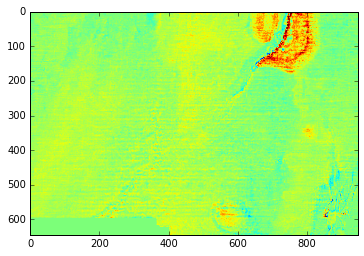

In [13]:
amplitude = np.clip(amplitude,-20000,20000)
plt.imshow(amplitude)
plt.show()

In [14]:
amplitude

array([[-2266.,     0.,     0., ...,     0.,     0.,     0.],
       [-2211., -1564.,  -756., ...,  -739.,  -733., -1125.],
       [-1117., -1460., -1341., ..., -1614., -1935., -1479.],
       ..., 
       [    0.,     0.,     0., ...,  -579.,   752.,  -259.],
       [    0.,     0.,     0., ..., -1071., -1260.,  -291.],
       [    0.,     0.,     0., ...,  -445.,   311.,   834.]])

## Symmetric nearest neighbour

In [15]:
def snn_old(horizon, kernel_size=5):
 
    # make an empty array the same shape as the input
    output = np.empty_like(horizon) 
    inlines, xlines = horizon.shape
    offset = kernel_size/2
 
    for x in range(int(inlines - 2*offset)):
        x += offset # Correct for offset
        for y in range(int(xlines - 2*offset)):
            y += offset
            centre = horizon[(x),(y)]
            nearest_neighbours = [centre]
            for a in range(kernel_size**2 // 2):
                i, j = divmod(a, kernel_size)
                i -= offset # transform to relative coordinates in kernel
                j -= offset
                value = horizon[int(x+i), int(y+j)]
                opposite = horizon[int(x-i), int(y-j)]
                closest = min(value-centre, opposite-centre)
                nearest_neighbours.append(closest+centre)
            output[x,y] = np.mean(nearest_neighbours)
 
    return output


In [127]:
%timeit x = snn_old(amplitude)

/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


1 loop, best of 3: 1min 23s per loop


In [20]:
x = snn_old(amplitude)

/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/matt/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [196]:
import scipy.ndimage

def snn(horizon, size=5, include=True):
    
    # TODO: See how it handles Nans,
    # Consider removing them, interpolate over them,
    # and put them back at end.
    
    def nearest(a, num):
        return a.flat[np.abs(a - num).argmin()]
    
    def func(this, pairs, include):
        centre = this[this.size // 2]
        select = [nearest(this[p], centre) for p in pairs]
        if include:
            select += [centre]
        return np.mean(select)

    pairs = [[i, size**2-1 - i] for i in range(size**2 // 2)]
    return scipy.ndimage.generic_filter(horizon, func, size=size,
                                        extra_keywords={'pairs': pairs,
                                                        'include': include}
                                       )


In [55]:
%timeit snn(amplitude)

1 loop, best of 3: 1min 2s per loop


In [72]:
y_ = snn(amplitude)

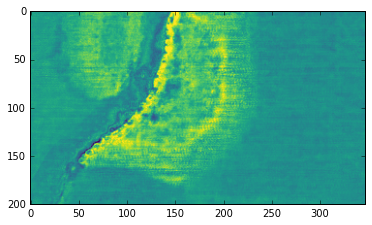

In [82]:
plt.imshow(amplitude[:200, 600:], cmap='viridis')

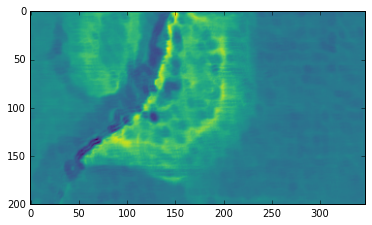

In [83]:
plt.imshow(x[:200, 600:], cmap='viridis')

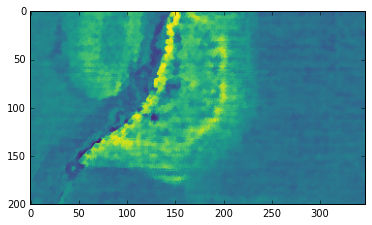

In [84]:
plt.imshow(y[:200, 600:], cmap='viridis')

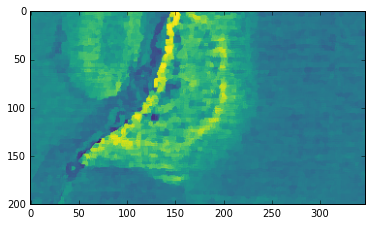

In [87]:
plt.imshow(z[:200, 600:], cmap='viridis')

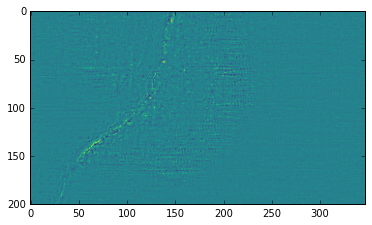

In [85]:
plt.imshow(y[:200, 600:] - y_[:200, 600:], cmap='viridis')

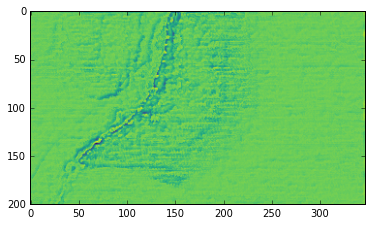

In [86]:
plt.imshow(x[:200, 600:] - y_[:200, 600:], cmap='viridis')

## Kuwahara

In [100]:
def kuwahara(horizon, size=5):

    # TODO: See how it handles Nans,
    # Consider removing them, interpolate over them,
    # and put them back at end.

    def func(this, s, k):
        t = this.reshape((s, s))
        sub = np.array([t[:k, :k].flatten(),
                        t[:k, k-1:].flatten(),
                        t[k-1:, :k].flatten(),
                        t[k-1:, k-1:].flatten()]
                       )
        select = sub[np.argmin(np.var(sub, axis=1))]
        return np.mean(select)

    if not size // 2:
        size += 1
        
    k = int(np.ceil(size / 2))

    return scipy.ndimage.generic_filter(horizon,
                                        func,
                                        size=size,
                                        extra_keywords={'s':size,
                                                        'k':k,
                                                       }
                                       )


In [101]:
%timeit kuwahara(amplitude)

1 loop, best of 3: 39 s per loop


In [ ]:
z = kuwahara(amplitude)

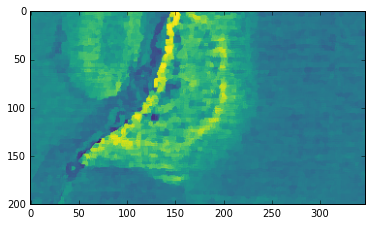

In [87]:
plt.imshow(z[:200, 600:], cmap='viridis')

## Conservative mean

In [194]:
def conservative(horizon, size=5, supercon=False):

    # TODO: See how it handles Nans,
    # Consider removing them, interpolate over them,
    # and put them back at end.

    def func(this, k, supercon):
        centre = this[k]
        rest = [this[:k], this[-k:]]
        mi, ma = np.nanmin(rest), np.nanmax(rest)
        if centre < mi:
            return mi if supercon else np.mean(rest)
        elif centre > ma:
            return ma if supercon else np.mean(rest)
        else:
            return centre

    if not size // 2:
        size += 1

    k = int(np.floor(size**2 / 2))

    return scipy.ndimage.generic_filter(horizon,
                                        func,
                                        size=size,
                                        mode='nearest',
                                        extra_keywords={'k':k,
                                                        'supercon': supercon,
                                                        }
                                        )


In [185]:
supercon = False
this = np.arange(25)
this[12] = -1
s = int(np.sqrt(this.size))
k = int(np.floor(this.size/2))
centre = this[k]
rest = [this[:k], this[-k:]]
mi, ma = np.nanmin(rest), np.nanmax(rest)
if centre < mi:
    centre = mi if supercon else np.mean(rest)
if centre > ma:
    centre = ma if supercon else np.mean(rest)
this = np.insert(rest, k, centre)
this

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [184]:
np.floor(5**2/2)

12.0

In [166]:
#w = conservative(amplitude)

In [122]:
#%timeit conservative(amplitude)

1 loop, best of 3: 20.9 s per loop


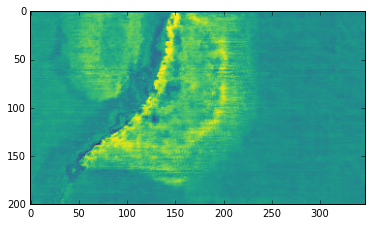

In [152]:
plt.imshow(w[:200, 600:], cmap='viridis')

In [192]:
this = np.arange(25).reshape((5,5))
this[2,2] = -1
this

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, -1, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [195]:
conservative(this, size=3, supercon=True)

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11,  6, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [176]:
snn(this, size=3)

array([[ 0,  0,  1,  2,  3],
       [ 2,  2,  3,  4,  9],
       [ 7,  7,  6, 10, 14],
       [12, 14, 15, 17, 19],
       [20, 20, 21, 22, 23]])

In [171]:
kuwahara(this, size=3)

array([[ 0,  0,  1,  2,  4],
       [ 2,  3,  4,  5,  6],
       [ 7,  8,  5, 11, 11],
       [12, 13, 19, 16, 16],
       [20, 20, 21, 22, 24]])

In [173]:
scipy.ndimage.generic_filter(this, np.mean, size=3, mode='nearest')

array([[ 2,  2,  3,  4,  5],
       [ 5,  4,  5,  6,  8],
       [10,  9, 10, 11, 13],
       [15, 14, 15, 16, 18],
       [18, 19, 20, 21, 22]])

In [189]:
a = np.testing.assert_array_equal(conservative(this, size=3, supercon=True), conservative(this, size=3, supercon=True))

In [190]:
a